In [3]:
import sys, platform, os
import numpy as np
import camb
import pandas as pd
import healpy as hp
from camb import model, initialpower
import useful_functions as uf
import pysm3
from fgbuster import (CMB, Dust, Synchrotron, basic_comp_sep,get_observation, get_instrument, get_sky)
from fgbuster.visualization import corner_norm
nside_patch = 16
nside=16
nside_compsep=nside_patch

instrument = get_instrument('LiteBIRD')
kind_of_map='d1s1'
cmb='c1'

#sky_vary = get_sky(NSIDE_PATCH, kind_of_map)
sky_vary = get_sky(nside, kind_of_map)
cmb_sky=get_sky(nside, cmb)

for spectral_param in [sky_vary.components[0].mbb_index,
                       sky_vary.components[0].mbb_temperature,
                       sky_vary.components[1].pl_index]:
    spectral_param[:] = hp.ud_grade(hp.ud_grade(spectral_param.value, nside_patch),
                                    nside) * spectral_param.unit
    print(spectral_param.unit)

unit=-3 #uk->mk 
sync_freq_maps = get_observation(instrument, sky_vary, noise=True, nside=nside,unit='mK_CMB') #, unit='uK_CMB')
cmb_freq = get_observation(instrument, cmb_sky, noise=False, nside=nside,unit='mK_CMB')
freq_maps=sync_freq_maps+cmb_freq
#print(cmb_freq)

/home/amorelli/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')



K



In [ ]:
#hp.mollview(cmb_freq[0,1])

In [4]:
#hp.mollview(sync_freq_maps[0,0])
#hp.mollview(sync_freq_maps[0,1])
#hp.mollview(sync_freq_maps[0,2])
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 12, 16

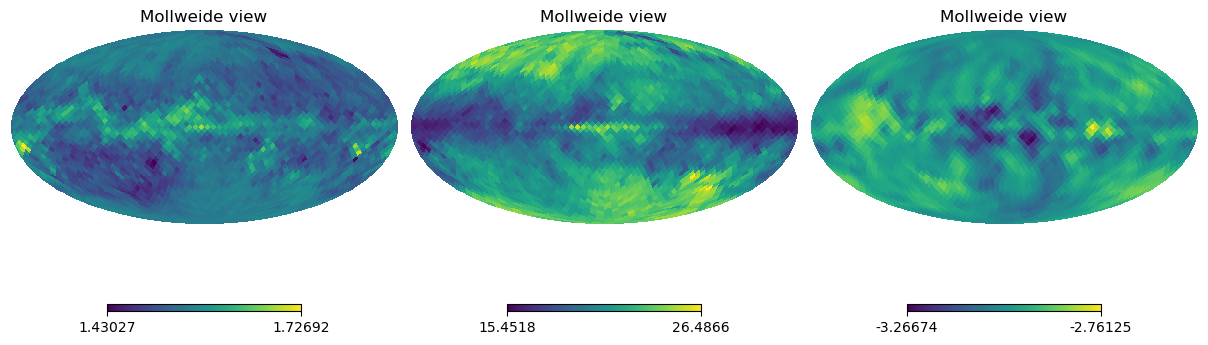

In [5]:
hp.mollview(sky_vary.components[0].mbb_index,sub=(1,3,1))
hp.mollview(sky_vary.components[0].mbb_temperature,sub=(1,3,2))
hp.mollview(sky_vary.components[1].pl_index,sub=(1,3,3))
mbb_index_mean=np.mean(np.abs(sky_vary.components[0].mbb_index))
mbb_temp_mean=np.mean(np.abs(sky_vary.components[0].mbb_temperature))
pl_mean=np.mean(np.abs(sky_vary.components[1].pl_index))

In [27]:
components = [CMB(), Dust(150.), Synchrotron(20.)]

# The starting point of the fit is the pysm default value, so let's shift it
#components[1].defaults = [1.6, 22.]
#components[2].defaults = [-2.7]

compsep_tot=basic_comp_sep(components, instrument, freq_maps[:,1:],nside=nside_compsep) #nside=0 is default
compsep=compsep_tot.s[0]

In [29]:
result_Q=compsep[0]-cmb_freq[0,1]
result_U=compsep[1]-cmb_freq[0,2]

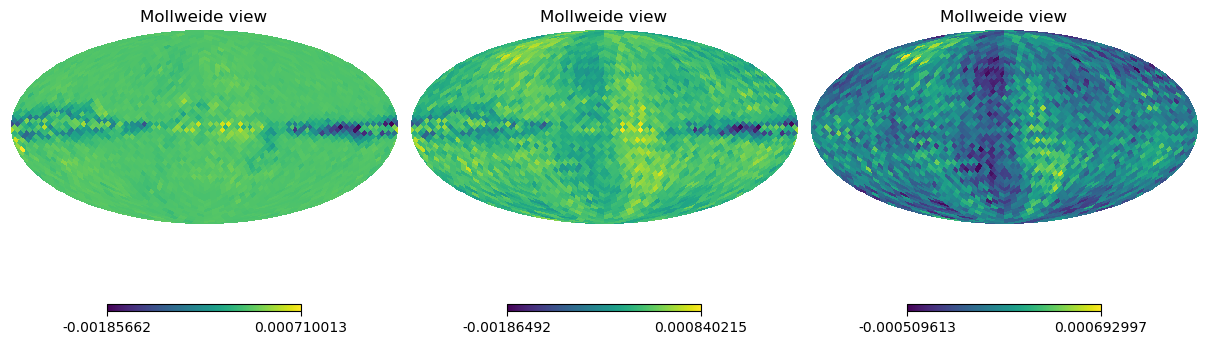

In [30]:
hp.mollview(result_Q,sub=(1,3,1))#,norm="hist")#,min=-1.5,max=1.5)
hp.mollview(compsep[0],sub=(1,3,2))#,norm="hist")#,min=-1.5,max=1.5)
hp.mollview(cmb_freq[0,1],sub=(1,3,3))

In [31]:
print(compsep_tot.params)

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']


3072
3072
3072


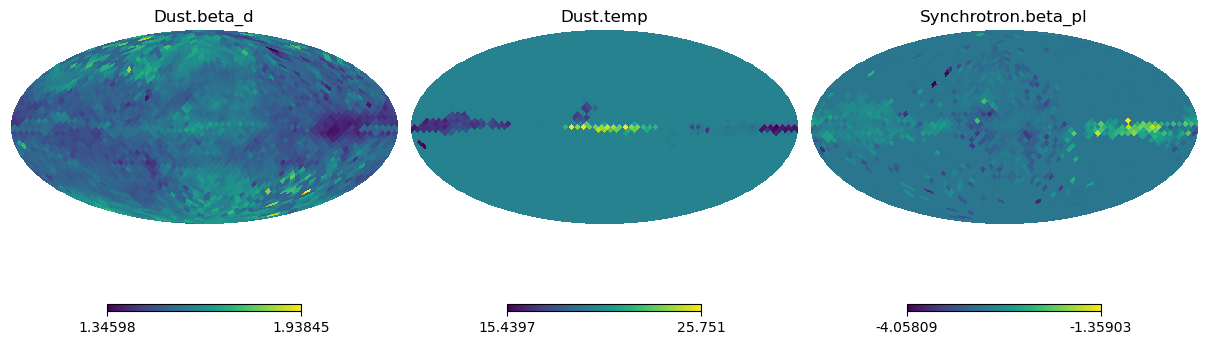

In [32]:
for i, par in enumerate(compsep_tot.params):
    print(len(compsep_tot.x[1]))
    hp.mollview(compsep_tot.x[i], title=par, sub=(1,3,i+1)) #you see that in this case you have one index for each healpix pixel while
    #for d0s0 case you had only one

0.02832228538102288 0.08327359315395862 1 / K 0.025875295347491542
1.5396922826766968 20.928674697875977 K 2.99999737739563


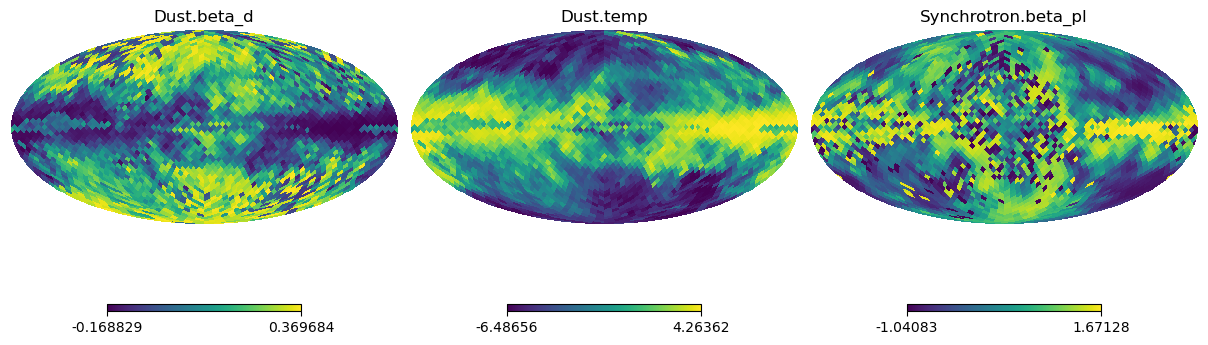

In [33]:
mbb_index_map=hp.ud_grade(compsep_tot.x[0], nside) - sky_vary.components[0].mbb_index
hp.mollview(mbb_index_map,
            title=compsep_tot.params[0], norm='hist', sub=(1,3,1))
mbb_temp_map=hp.ud_grade(compsep_tot.x[1], nside) - sky_vary.components[0].mbb_temperature.value
hp.mollview(mbb_temp_map,
            title=compsep_tot.params[1], norm='hist', sub=(1,3,2))
pl_map=hp.ud_grade(compsep_tot.x[2], nside) - sky_vary.components[1].pl_index
hp.mollview(pl_map,
            title=compsep_tot.params[2], norm='hist', sub=(1,3,3))
print(np.mean(np.abs(mbb_index_map))/mbb_index_mean,
      np.mean(np.abs(mbb_temp_map))/mbb_temp_mean,
      np.mean(np.abs(pl_map))/pl_mean)
print(mbb_index_mean,
      mbb_temp_mean,
      pl_mean)

In [34]:
result_Q*=10**-unit
res=hp.nside2resol(nside, arcmin=True)
mean_Q=np.mean(result_Q)
std_Q=np.std(result_Q)
sensitivity_Q=std_Q*res
print(mean_Q,std_Q,sensitivity_Q)

-0.0381951348288777 0.18860972351906755 41.46983310632924


In [35]:
result_U*=10**-unit
mean_U=np.mean(result_U)
std_U=np.std(result_U)
sensitivity_U=std_U*res
print(mean_U,std_U,sensitivity_U)

-0.00026024896906912354 0.07273776003470472 15.992933518416848


In [18]:
E_maps, B_maps = uf.convert_to_EB(result)

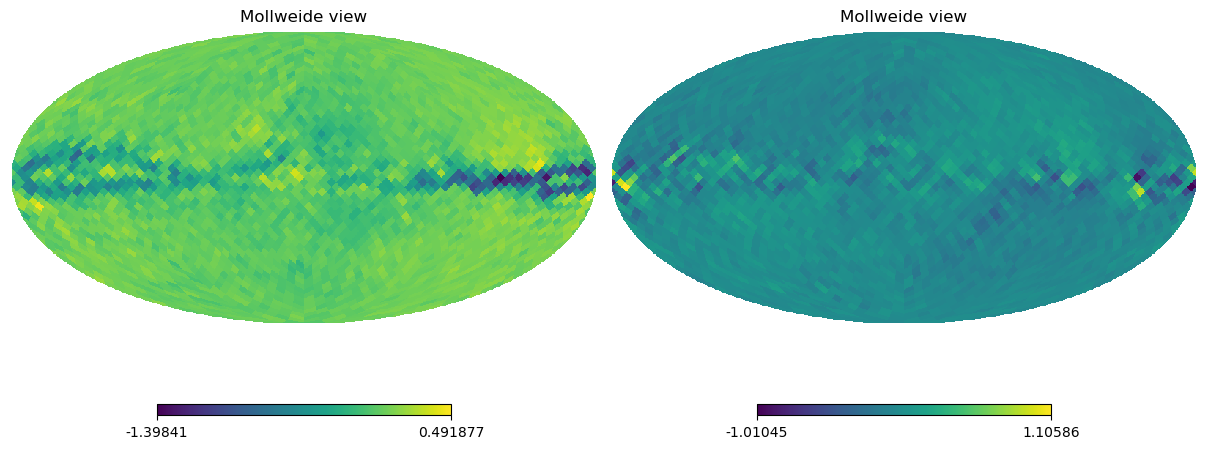

In [19]:
hp.mollview(E_maps[0,:,0], sub=(1,2,1))
hp.mollview(B_maps[0,:,0], sub=(1,2,2))
#hp.mollview(E_maps[0,:,0]-B_maps[0,:,0])

In [20]:
mean_E=np.mean(E_maps[0,:,0])
std_E=np.std(E_maps[0,:,0])
sensitivity_E=std_E*res
print(mean_E,std_E,sensitivity_E)

1.6384592443996714e-05 0.17359834279646547 38.16926385864174


In [21]:
mean_B=np.mean(B_maps[0,:,0])
std_B=np.std(B_maps[0,:,0])
sensitivity_B=std_B*res
print(mean_B,std_B,sensitivity_B)

-1.996311248030879e-06 0.11521951118875394 25.333444164173294


In [9]:
pol=2
n_maps, n_pix, n_channels = (result.shape[0],result.shape[1],int(result.shape[2]/pol))
nside=hp.npix2nside(n_pix)
#print(n_maps,n_pix,nside,n_channels)
result_2=np.empty_like(result)
mappe_placeholder=np.zeros((n_maps,n_pix))
for i in range(n_maps):
    for k in range(n_channels):
        alm=hp.map2alm([mappe_placeholder[i,:],result[i,:,k*pol],result[i,:,k*pol+1]], pol=True, verbose=True)
        mappp, result_2[i,:,k*n_channels],result_2[i,:,k*n_channels+1]=hp.alm2map(alm, nside, pol=True, verbose=True)

In [10]:
mean_Q2=np.mean(result_2[0,:,0])
std_Q2=np.std(result_2[0,:,0])
sensitivity_Q2=std_Q2*res
print(mean_Q2,std_Q2,sensitivity_Q2)

-0.24785665325133222 0.9666458447523871 212.53751453994136


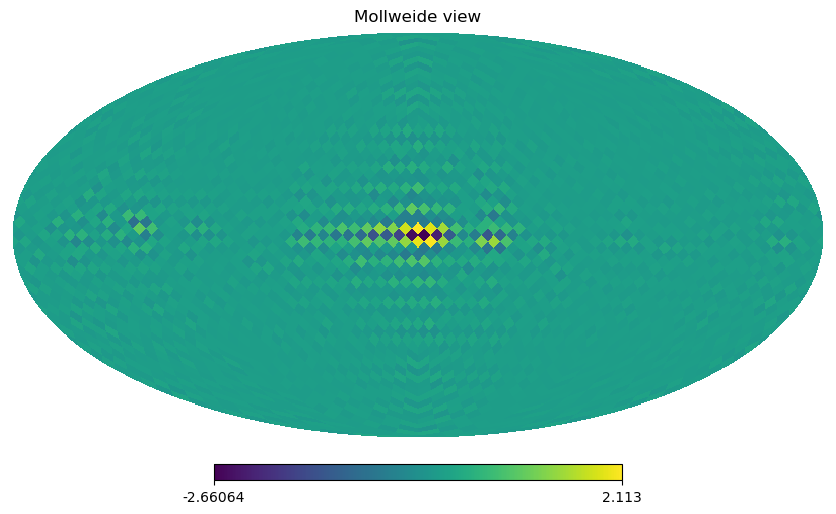

In [11]:
hp.mollview(result[0,:,0]-result_2[0,:,0])

In [12]:
beam_w=0.01*hp.nside2resol(nside, arcmin=False)
lmax=len(data[0,0,:])
print(lmax)
beam=hp.gauss_beam(beam_w, lmax=lmax)
pol=2
result_3=np.empty_like(result)
for i in range(n_maps):
    for k in range(n_channels):
        alm=hp.map2alm([mappe_placeholder[i,:],hp.smoothing(result[i,:,k*pol],fwhm=beam_w)
                        ,hp.smoothing(result[i,:,k*pol+1],fwhm=beam_w)]
                        , pol=True, verbose=True)
        #alm_wb = np.array([hp.almxfl(each,beam) for each in alm]) #i multiply the alm by the window functions
        mappp, result_3[i,:,k*n_channels],result_3[i,:,k*n_channels+1]=hp.alm2map(alm, nside, pol=True, verbose=True)

47


In [13]:
mean_Q3=np.mean(result_3[0,:,0])
std_Q3=np.std(result_3[0,:,0])
sensitivity_Q3=std_Q3*res
print(mean_Q3,std_Q3,sensitivity_Q3)

-0.24784130919152036 0.9665606713615779 212.51878737022784


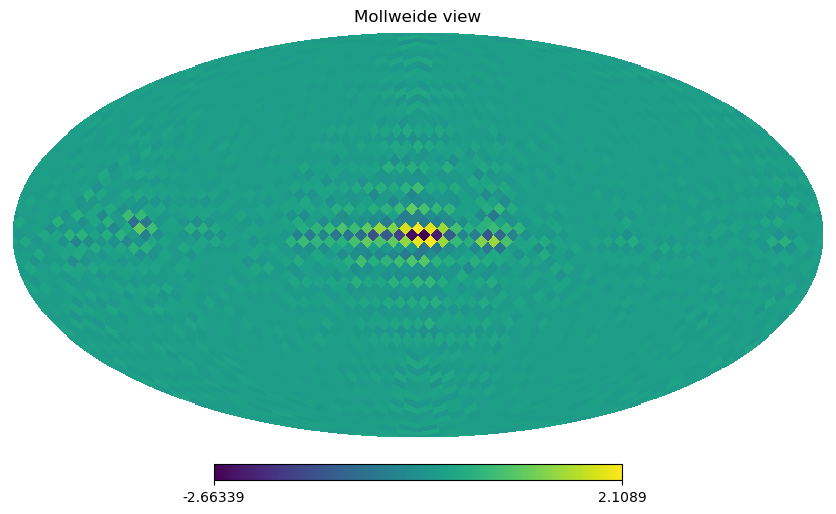

In [14]:
hp.mollview(result[0,:,0]-result_3[0,:,0])

In [15]:
pol=2
result_4=np.empty_like(result)
mappe_placeholder=np.zeros((n_maps,n_pix))
for i in range(n_maps):
    for k in range(n_channels):
        cl=hp.anafast([hp.remove_monopole(mappe_placeholder[i,:]),
                           hp.remove_monopole(result[i,:,k*pol]),hp.remove_monopole(result[i,:,k*pol+1])],lmax=lmax-1,pol=True)
        alm= hp.synalm((cl[0], cl[1], cl[2], cl[3]), lmax=lmax, new=True)
        mappp, result_4[i,:,k*n_channels],result_4[i,:,k*n_channels+1]=hp.alm2map(alm, nside, pol=True, verbose=True)

In [16]:
mean_Q4=np.mean(result_4[0,:,0])
std_Q4=np.std(result_4[0,:,0])
sensitivity_Q4=std_Q4*res
print(mean_Q4,std_Q4,sensitivity_Q4)

0.21509113343814357 0.684577399066338 150.51880654910119


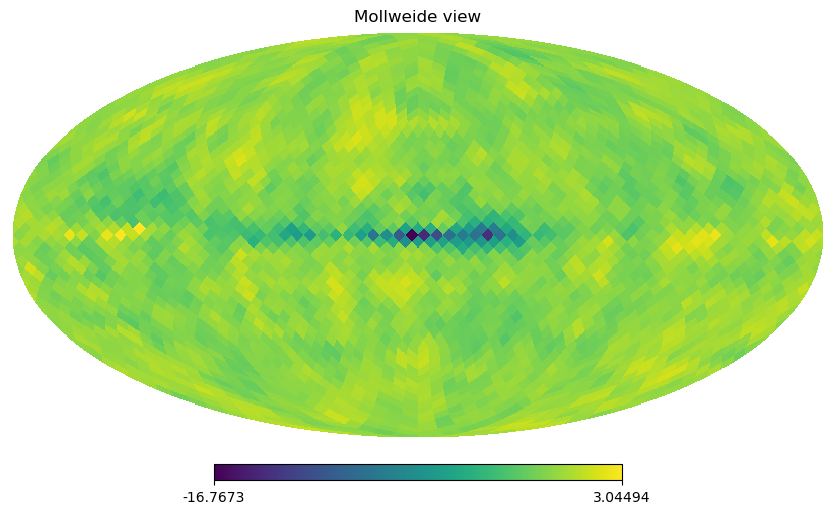

In [17]:
hp.mollview(result[0,:,0]-result_4[0,:,0])